# 시험장 환경 정보

Python: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]

|모듈|버젼|
|----|----|
|pandas|0.25.1|
|numpy|1.18.5|
|sklearn|0.21.3|
|scipy|1.5.2|
|mlxtend|0.15.0.0|
|statsmodels|0.11.1|

실습강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com)

In [1]:
# 실행 환경 확인

import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels
import mlxtend
import sys

print(sys.version)
for i in [pd, np, sklearn, scipy, mlxtend, statsmodels]:
    print(i.__name__, i.__version__)

3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 20:34:20) [MSC v.1916 64 bit (AMD64)]
pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
mlxtend 0.15.0.0
statsmodels 0.11.1


In [2]:
# 시각화 모듈 설정
# 참고용 차트를 출력하기 위함

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
import matplotlib.font_manager as fm
plt.rc('font', family='Malgun Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# 문제 개요

다음은 폴더블 폰의 힌지에 들어가는 스프링 내구력을 테스트한 실험 결과이다. 

스프링 측정값과 스프링에 가한 부하 정보와 함께, 테스트 통과/실패 (failure) 결과가 기재되어 있다. 

개발부서는 테스트 비용을 줄이기 위해 failure 여부를 맞추는 모델을 만들고자 한다.

변수명은 보안을 위해 measurement_0과 같이 익명화되었다.

데이터 구성

학습데이터: train_prob.csv, 21,458 rows, 25 columns

테스트데이터: test_prob.csv, 5,112 rows, 24 columns, 

테스트정답셋: test_prob_ans.csv, 5,112 rows, 1 columns


컬럼명	설명	타입

|변수명|설명|타입|
|--|--------------|------|
|id|실험 고유 번호|정수형|
|product_code|스프링 코드|범주형|
|loading|스프링에 가한 부하|실수형|
|attribute_0|구성 소재1|범주형|
|attribute_1|구성 소재2|범주형|
|attribute_2|구성 소재3|정수형|
|attribute_3|구성 소재4|정수형|
|measurement_0 ~ 17|측정값 0~17|실수형|
|failure|성공여부|이진형(0, 1)|


# 전처리(Preprocessing)

train_prob.csv를 불러 온다. 이를 basetable이리고 한다.

In [3]:
df_basetable = pd.read_csv('train_prob.csv', index_col='id')
df_basetable.head()

product_code  loading attribute_0 attribute_1  attribute_2  attribute_3  \
id                                                                           
0             A    80.10  material_7  material_8            9            5   
1             A    84.89  material_7  material_8            9            5   
2             A    82.43  material_7  material_8            9            5   
3             A   101.07  material_7  material_8            9            5   
4             A   188.06  material_7  material_8            9            5   

    measurement_0  measurement_1  measurement_2  measurement_3  ...  \
id                                                              ...   
0               7              8              4         18.040  ...   
1              14              3              3         18.213  ...   
2              12              1              5         18.057  ...   
3              13              2              6         17.295  ...   
4               9              2              8         19.346  ...   

    measurement_9  measurement_10  measurement_11  measurement_12  \
id                                                                  
0          10.672          15.859          17.594          15.193   
1          12.448          17.947          17.915          11.755   
2          12.715          15.607             NaN          13.798   
3          12.471          16.346          18.377          10.020   
4          10.337          17.082          19.932          12.428   

    measurement_13  measurement_14  measurement_15  measurement_16  \
id                                                                   
0           15.029             NaN          13.034          14.684   
1           14.732          15.425          14.395          15.631   
2           16.711          18.631          14.094          17.946   
3           15.250          15.562          16.154          17.172   
4           16.182          12.760          13.153          16.412   

    measurement_17  failure  
id                           
0          764.100        0  
1          682.057        0  
2          663.376        0  
3          826.282        0  
4          579.885        0  

[5 rows x 25 columns]

In [4]:
df_basetable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21458 entries, 0 to 26569
Data columns (total 25 columns):
product_code      21458 non-null object
loading           21257 non-null float64
attribute_0       21458 non-null object
attribute_1       21458 non-null object
attribute_2       21458 non-null int64
attribute_3       21458 non-null int64
measurement_0     21458 non-null int64
measurement_1     21458 non-null int64
measurement_2     21458 non-null int64
measurement_3     21146 non-null float64
measurement_4     21016 non-null float64
measurement_5     20893 non-null float64
measurement_6     20818 non-null float64
measurement_7     20692 non-null float64
measurement_8     20605 non-null float64
measurement_9     20469 non-null float64
measurement_10    20399 non-null float64
measurement_11    20278 non-null float64
measurement_12    20171 non-null float64
measurement_13    20063 non-null float64
measurement_14    19976 non-null float64
measurement_15    19855 non-null float64
me

# 단계 1

basetable에 measurement_3 ~17 각각의 행이 결측인지 나타내는 파생 변수를 만든다. 

파생 변수는 이진 형식이고, False는 미결측 True는 결측을 의미한다. 

파생 변수의 이름은 measurement 번호에 따라 isna_3 ~ 17로 한다. 

In [5]:
df_basetable[['isna_{}'.format(i) for i in range(3, 18)]] = \
        df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].isna()

In [6]:
df_basetable[['isna_{}'.format(i) for i in range(3, 18)]].sum()

isna_3      312
isna_4      442
isna_5      565
isna_6      640
isna_7      766
isna_8      853
isna_9      989
isna_10    1059
isna_11    1180
isna_12    1287
isna_13    1395
isna_14    1482
isna_15    1603
isna_16    1708
isna_17    1818
dtype: int64

## 단계 2

이 과제를 맡은 데이터분석가 지희는 measurement_3~17의 결측치 처리 방안을 고민하던 중, 

개발부서에서 measurement_17은 product_code별로 failure를 예측하기 위해 

measurement_3 ~ measurement_9을 다음과 같이 선형 조합하여 생성한 값이라는 정보를 받았다. 

$measurement_{17}=\beta_{3}measurement_{3}+\beta_{4}measurement_{4}+...+\beta_{9}measurement_{9} + \beta_{0}$

이는 즉,

$measurement_{3}=\beta'_{4}measurement_{4}+\beta'_{5}measurement_{5}+...+\beta'_{17}measurement_{17} + \beta'_{0}$

...

$measurement_{9}=\beta''_{3}measurement_{3}+\beta''_{4}measurement_{4}+...+\beta''_{17}measurement_{17} + \beta''_{0}$

와 같이 measurement_3 ~ measurement_9의 각 변수들도 나머지 변수들과 선형 관계를 지닌다. 

이 점을 이용하여 대상 변수를 번갈아 가면서 예측 모델을 만들어 최대한 원래 값에 가깝게 복원할 수 있다. 

이러한 반복적인 결측치 복원 방법을 사내 데이터분석 연구소에 문의 했더니 다음과 같은 가이드를 주었다. 

> sklearn 모듈에 아직은 실험 단계이지만, 비슷한 경우에 문제 없이 사용했던 사례가 있어 의견을 드립니다. 

> from sklearn.experimental import enable_iterative_imputer 구문을 사용하여 실험 단계인 모듈을 활성화하고, 

> sklearn.impute.IterativeImputer를 사용한다면 원하는 결과를 얻을 수 있습니다.

가이드의 내용을 참조하여 basetable의 measurement_3~9와 measurement_17 결측치를 복원하라.


입력 변수] measurement_3 ~ 9, measurement_17 (입력 변수 순서에 유의)

---
**함수가이드**

sklearn.experimental.enable_iterative_imputer

sklearn.impute.IterativeImputer, random_state=123

sklearn.linear_model.LinearRegression

문제 지시사항 외 Default 값 사용

---


In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

In [8]:
# 방법1 GroupBy를 통한 방법 
# 모델을 생성합니다.
def create_imp():
    return  IterativeImputer(LinearRegression(),random_state = 123)

X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
# product_code 각각에 대해 create_imp로 모델을 생성하고, 학습을 시킵니다.
s_imp = df_basetable.groupby('product_code').apply(lambda x: create_imp().fit(x[X_imp]))
# 생성하고 학습한 모델을 가지고, 결측치를 보완합니다.
df_basetable[X_imp] = df_basetable.groupby('product_code').apply(
    lambda x: pd.DataFrame(s_imp.loc[x.name].transform(x[X_imp]), index=x.index, columns=X_imp)
)

In [9]:
# 방법2 반복문을 통한 방법입니다
X_imp = ['measurement_{}'.format(i) for i in range(3, 10)] + ['measurement_17']
for c in df_basetable['product_code'].unique():
    s_idx = df_basetable['product_code'] == c # Boolean 인덱스를 만듭니다
    df_basetable.loc[s_idx, X_imp] = \
                IterativeImputer(LinearRegression(),random_state = 123).fit_transform(df_basetable.loc[s_idx, X_imp])

In [10]:
# 참고용 코드입니다.
# 회귀계수와 절편을 확인합니다.
X_lr = ['measurement_{}'.format(i) for i in range(3, 10)]
target = 'measurement_17'
s_lr = df_basetable.dropna().groupby('product_code')\
            .apply(lambda x: LinearRegression().fit(x[X_lr], x[target]))
s_lr.apply(lambda x: pd.Series(x.coef_, index=X_lr))\
        .join(s_lr.apply(lambda x: x.intercept_).rename('intercept'))

measurement_3  measurement_4  measurement_5  measurement_6  \
product_code                                                               
A                 -0.013296      14.881172      59.773099      26.734050   
B                 18.531550      44.463190      34.964489       0.008867   
C                  0.022284      -0.011787      52.478159       7.179577   
E                  0.018925      58.692024      66.619064      77.096975   

              measurement_7  measurement_8  measurement_9    intercept  
product_code                                                            
A                 25.166727      77.346608       0.004715 -2732.252301  
B                 87.465394       0.001072      26.750054 -2079.917247  
C                 41.669177      91.218688      36.497110 -2964.800183  
E                 -0.031772      73.149330      19.942539 -4097.945504

In [11]:
# 참고용 코드입니다.
# r-square를 봅니다.
from sklearn.metrics import r2_score
df_basetable.dropna().groupby('product_code').apply(
    lambda x: r2_score(x[target], s_lr.loc[x.name].predict(x[X_lr]))
)

product_code
A    0.999982
B    0.999984
C    0.999986
E    0.999990
dtype: float64

## 단계 3

measurement_10~16까지의 결측치는 모두 product_code별 평균으로 대치한다.

In [12]:
# 방법 1: groupby ~ apply를 사용합니다.
cols = ['measurement_{}'.format(i) for i in range(10, 17)]
df_basetable[cols] = df_basetable.groupby('product_code')[cols].apply(
    lambda x: pd.DataFrame(x.fillna(x.mean()), index=x.index)
)

In [13]:
# 방법 2: groupby ~ transform을 사용합니다.
cols = ['measurement_{}'.format(i) for i in range(10, 17)]
df_basetable[cols] = df_basetable.groupby('product_code')[cols].transform(
    lambda x: x.fillna(x.mean())
)

Hint] 전처리 단계에서 보간 결과를 확인해 보기 위한 각 변수의 평균과 표본표준편차.

| |3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|
|-|-|-|-|-|-|-|-|--|--|--|--|--|--|--|--|
|mean|17.796|11.736|17.131|17.506|11.719|19.022|11.434|16.034|19.194|11.734|15.666|16.033|15.051|16.398|701.768|
|std|0.997|0.994|0.994|0.992|0.993|1.005|0.997|1.278|1.579|1.433|1.149|1.461|1.478|1.671|119.180|

열의 이름의 숫자는 measurement_ 번호, 값은 소수점 3째 자리까지 반올림

In [14]:
# 전처리 결과를 확인해 봅니다.
df_basetable[['measurement_{}'.format(i) for i in range(3, 18)]].agg(['mean', 'std'])\
    .rename(columns=lambda x: x.split('_')[1]).applymap(lambda x: round(x, 3))

3       4       5       6       7       8       9      10      11  \
mean  17.796  11.736  17.131  17.506  11.719  19.022  11.434  16.034  19.194   
std    0.997   0.994   0.994   0.992   0.993   1.005   0.997   1.278   1.579   

          12      13      14      15      16       17  
mean  11.734  15.666  16.033  15.051  16.398  701.768  
std    1.433   1.149   1.461   1.478   1.671  119.180

# 문제1

(basetable을 사용) measurement_3~16까지 결측 여부가 failure에 영향이 있는지를 파악하고, 

failure를 분류하는 데 도움이 될 만한 것은 예측 모델의 입력 변수로 사용하고자 한다. 

이를 위해 전처리 과정에서 뽑아낸 isna_3~16을 활용한다.

n이 3부터 16까지, 즉 measurement_3~16까지 다음의 검정을 수행한다. 

$H_0: P(failure=True|measurement_{n}=Missing)=P(failure=True)$

$H_1: P(failure=True|measurement_{n}=Missing) \neq P(failure=True)$

모집단의 $P(failure=True) = 0.2114$


## 단계 1-1

우선, measurement_3으로 위 검정을 시행해보자.

$H_0: P(failure=True|isna_{3}=True)=0.2114$

$H_1: P(failure=True|isna_{3}=True) \neq 0.2114$

으로 바꿀 수 있다.

$P(failure=True|isna_{3}=True)$은 표본수가 충분하여 중심극한정리에 의해 정규분포를 따르는 것은 분석가 간에 이견이 없다고 한다. 

위 검정의 p-value를 구하여 보고 힌트에 주어진 p-value와 비교하여 검정 방법에 문제가 없음을 확인하라.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---

 Hint] p-value는 0.0037(소수점 다섯째 자리에서 반올림하여 넷째 자리까지 표시)


In [15]:
from scipy.stats import norm
P_true = 0.2114 # 모집단의 평균(비율)
P_var = P_true * (1 - P_true) # 모집단의 분산을 구합니다.
n_sample = df_basetable['isna_3'].sum() # 샘플분산을 구하기 위해 샘플의 수를 구합니다.
P_sample_var = P_var / n_sample # 샘플 분산
P_sample_true = df_basetable.loc[df_basetable['isna_3'], 'failure'].mean() # 샘플의 failure 비율 (관측치)
# 표준정규분포에 왼쪽 꼬리 영역의 통계량 산출합니다. 
#일반적인 케이스를 다루기 위해 절대값에 음수를 취합니다.
Z = -abs(P_sample_true - P_true) / (P_sample_var ** 0.5)
pvalue = norm.cdf(Z) * 2
P_true, P_var, n_sample, P_sample_var, P_sample_true, Z, pvalue

(0.2114,
 0.16671004,
 312,
 0.0005343270512820513,
 0.14423076923076922,
 -2.905807189028007,
 0.0036630709140241546)

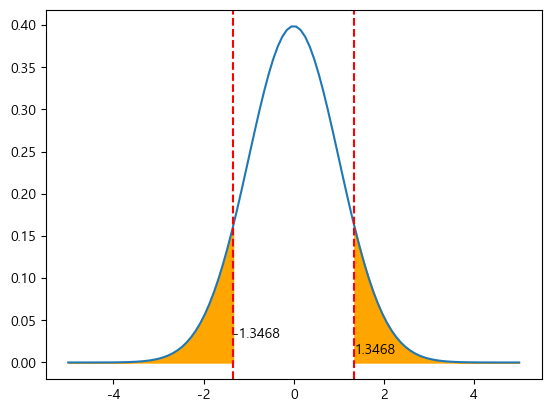

In [16]:
from scipy.stats import norm
# 표준정규 분포를 이용한 pvalue 도출을 그래프로 설명합니다.
col = 'isna_{}'.format(4)
P_var = P_true * (1 - P_true)
n_samples = df_basetable[col].sum()
P_missing_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
P_missing_var = P_var / n_samples
P_missing_std = P_missing_var ** 0.5

stat = -abs((P_missing_true - P_true) / P_missing_std)

plt.plot(np.linspace(-5, 5, 100), norm.pdf(np.linspace(-5, 5, 100)))
plt.axvline(stat, color='red', linestyle='--')
plt.text(stat, 0.03, str(stat)[:7])
plt.axvline(-stat, color='red', linestyle='--')
plt.text(-stat, 0.01, str(-stat)[:6])
plt.fill_between(np.linspace(-5, stat, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-5, stat, 100)), color='orange')
plt.fill_between(np.linspace(-stat, 5, 100), np.zeros(shape=100),
                norm.pdf(np.linspace(-stat, 5, 100)), color='orange')

plt.show()

In [17]:
# 방법 2 
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
    df_basetable.loc[df_basetable['isna_3'], 'failure'].sum(), # failure의 샘플수입니다.
    df_basetable['isna_3'].sum(), # 관측한 샘플수입니다
    0.2114, # 귀무가설에서의 비율
    'two-sided', # 양측검정으로 설정합니다.
    0.2114 # prop_var - 모분산을 구하기 위한 비율
)

(-2.905807189028007, 0.0036630709140241546)

## 단계 1-2

measuremenet_3을 포함하여 measurement_4 ~ 16까지 위 검정을 반복하고 

귀무가설을 기각할 수 있는 경우의 p-value의 합을 A라고 한다. (유의 수준은 5%로 한다.)

In [18]:
A = 0
for i in range(3, 17):
    col = 'isna_{}'.format(i)
    P_true = 0.2114
    P_var = P_true * (1 - P_true)
    n_sample = df_basetable[col].sum()
    P_sample_var = P_var / n_sample
    P_sample_true = df_basetable.loc[df_basetable[col], 'failure'].mean()
    Z = -abs(P_sample_true - P_true) / (P_sample_var ** 0.5)
    pvalue = norm.cdf(Z) * 2
    if pvalue < 0.05: # 귀무가설을 기각할 수 있는지 조사합니다
        A += pvalue
        print("*", col, P_sample_true, Z, pvalue)
    else:
        print(col, P_sample_true, Z, pvalue)
A

* isna_3 0.14423076923076922 -2.905807189028007 0.0036630709140241546
isna_4 0.23755656108597284 -1.3468241702718833 0.17803686833140808
* isna_5 0.24955752212389382 -2.2213833417706925 0.026325008335499278
isna_6 0.215625 -0.2617796136561279 0.793491357072205
isna_7 0.2245430809399478 -0.8909035498642803 0.37298091572329806
isna_8 0.20164126611957797 -0.6980509343383379 0.48514534123655306
isna_9 0.21840242669362994 -0.5393439841397007 0.589649524697301
isna_10 0.22096317280453256 -0.7622002829475777 0.44594047726157915
isna_11 0.21016949152542372 -0.1035248797832757 0.9175464043670771
isna_12 0.21833721833721834 -0.6095281379895136 0.5421744277936988
isna_13 0.2064516129032258 -0.45265767845606597 0.6507952588133231
isna_14 0.21862348178137653 -0.681066949794218 0.49582912857498873
isna_15 0.2114784778540237 -0.0076954319495023404 0.9938599942603648
isna_16 0.2066744730679157 -0.4783142261813061 0.6324265724265041


0.029988079249523434

## 단계 1-3

검정 결과 귀무가설을 기각할 수 있는 경우는 총 두 건이다. 

해당 파생 변수명의 뒷 자리 번호 순으로 na_1, na_2로 파생 변수를 만들어 prob1 데이터셋을 생성하라.

In [19]:
# 단계 1-2에서 isna_3, isna_5 경우에 귀무가설이 기각 됐습니다.
df_prob1 = df_basetable.assign(
    na_1 = lambda x: x['isna_3'], # isna_3를 na_1 변수로 만듭니다
    na_2 = lambda x: x['isna_5']  # isna_5를 na_2 변수로 만듭니다
)
df_prob1.head()

product_code  loading attribute_0 attribute_1  attribute_2  attribute_3  \
id                                                                           
0             A    80.10  material_7  material_8            9            5   
1             A    84.89  material_7  material_8            9            5   
2             A    82.43  material_7  material_8            9            5   
3             A   101.07  material_7  material_8            9            5   
4             A   188.06  material_7  material_8            9            5   

    measurement_0  measurement_1  measurement_2  measurement_3  ...  isna_10  \
id                                                              ...            
0               7              8              4         18.040  ...    False   
1              14              3              3         18.213  ...    False   
2              12              1              5         18.057  ...    False   
3              13              2              6         17.295  ...    False   
4               9              2              8         19.346  ...    False   

    isna_11  isna_12  isna_13  isna_14  isna_15  isna_16  isna_17   na_1  \
id                                                                         
0     False    False    False     True    False    False    False  False   
1     False    False    False    False    False    False    False  False   
2      True    False    False    False    False    False    False  False   
3     False    False    False    False    False    False    False  False   
4     False    False    False    False    False    False    False  False   

     na_2  
id         
0   False  
1   False  
2   False  
3   False  
4   False  

[5 rows x 42 columns]

A의 값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오. 

**0.030**


# 문제 2

첫째는 스프링 개발 업체들은 실험이 제품 별로 공정하게 진행이 됐는지를 의문을 가지고 있다.

product_code에 따라 개발 업체가 다르다. 

product_code에 대해서 스프링에 가한 부하(loading)를 동일하게 했는지 조사하라.

둘째는, attribute_0와 attribute_1은 스프링을 구성하는 주요 소재이다. 

failure와는 관계가 없음이 이전에 검증되었다. 

하지만, 이에 대한 재확인 요청을 받아 attribute_0와 attribute_1은 failure와 상관없음을 확인한다.

이를 위해 다음 단계를 수행하라.


## 단계 2-1

prob1에서 입력 변수 loading에 결측이 없는 행들을 뽑아 prob2 데이터프레임을 만든다.

Hint] prob2의 데이터 수는 21,257 이다.


In [20]:
df_prob2 = df_prob1.loc[df_prob1['loading'].notna()].copy()
df_prob2.shape

(21257, 42)

## 단계 2-2

prob2에 loading의 각 행들에 자연 로그 함수를 적용하여 파생 변수 loading_log를 만든다.


In [21]:
df_prob2['loading_log'] = np.log(df_prob2['loading']) # 자연 로그 함수 np.log 입니다.

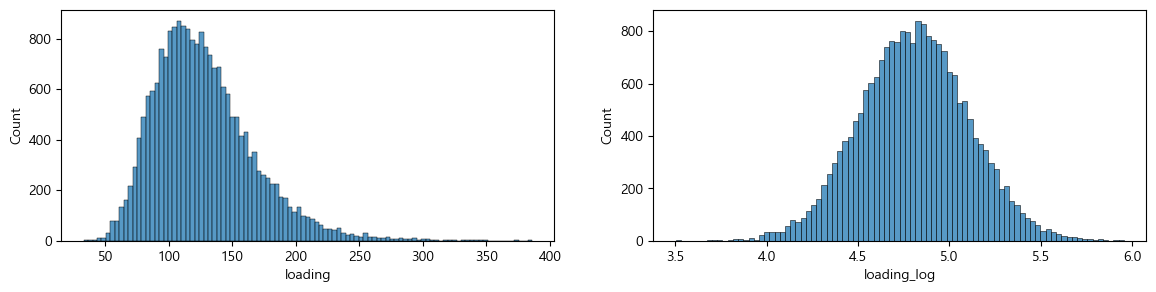

In [22]:
# 로그 변환이 어떤 효과를 보였는지, 보여주기 위한 참고용 코드입니다.
# 좌측으로 치우친 loading 변수가 log 변환을 통해 좌우 대칭형으로 변환되었음을 확인할 수 있습니다.

fig, axes = plt.subplots(1, 2, figsize=(14, 3) )
sns.histplot(data=df_prob2, x='loading', ax=axes[0])
sns.histplot(data=df_prob2, x='loading_log', ax=axes[1])
plt.show()

In [23]:
# 정규 분포와 얼마나 가까워졌는지 확인해봅니다.
from scipy.stats import kstest
from scipy.stats import norm, zscore
(
    kstest(zscore(df_prob2['loading'], ddof=1), norm.cdf),  # ddof=1이면, 표본표준편차 / ddof=0이면 모표준편차로 z변환하는 겁니다
    kstest(zscore(df_prob2['loading_log'], ddof=1), norm.cdf) 
)

(KstestResult(statistic=0.0600601378226141, pvalue=4.251798083024511e-67),
 KstestResult(statistic=0.004268034315027425, pvalue=0.8318549070535131))

## 단계 2-3

loading_log가 product_code 각각에 대해서 정규성을 지니고 있는지 확인하고자 한다.

이를 위해 Jarque-Bera로 검정하고 결과의 p-value가 0.05가 넘는 product_code의 수를 B라고 하자.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [24]:
from scipy.stats import jarque_bera
# 방법 1: 반복문
for i in df_prob2['product_code'].unique():
    print(i, jarque_bera(df_prob2.loc[df_prob2['product_code'] == i, 'loading_log']))
B = 3
B

A Jarque_beraResult(statistic=1.467731470333654, pvalue=0.4800496537264637)
B Jarque_beraResult(statistic=0.6168837955943998, pvalue=0.7345906322931469)
C Jarque_beraResult(statistic=7.536229242478234, pvalue=0.023095566154546443)
E Jarque_beraResult(statistic=0.04839464502051384, pvalue=0.9760930856160965)


3

In [25]:
# 방법 2: GroupBy
# product_code별로 loading_log를 jarque_bera에 전달합니다
# pd.Series로 만들어 결과를 정리합니다.
# unstack으로 인덱스에 위치한 stat, pvalue를 컬럼으로 전환시킵니다.
df_prob2.groupby('product_code')['loading_log']\
    .apply(lambda x: pd.Series(jarque_bera(x), index=['stat', 'pvalue']))\
    .unstack()\
    .pipe(lambda x: x.loc[x['pvalue'] > 0.05])
B = 3
B

3

## 단계 2-4

loading_log 변수를 product_code로 구분했을 때, 

등분산성을 보이는지 Bartlett 검정을 통해 확인한다.

검정 결과에서 p-value를 C라고 한다.

---

**함수 가이드**

 scipy.stats 에서 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [26]:
from scipy.stats import bartlett

In [27]:
# 방법 1: 하드코딩
result_2_4 = bartlett(
    df_prob2.loc[df_prob2['product_code'] == 'A', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'B', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'C', 'loading_log'],
    df_prob2.loc[df_prob2['product_code'] == 'E', 'loading_log']
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

In [28]:
# 방법 2: GroupBy
# groupby + agg(list)를 통헤 product_code 별로 loading_log의 리스트 객체로 만들어 Series로 만듭니다
# tolist 명령을 통해 Series를 리스토 만들고
# *: list unpacking 연산을 통해 리스트를 풀어 안에 있는 내용을 전달합니다.
result_2_4 = bartlett(
    *df_prob2.groupby('product_code')['loading_log'].agg(list).tolist() 
)
C = result_2_4.pvalue
result_2_4, C

(BartlettResult(statistic=1.928667047072185, pvalue=0.5873433093297675),
 0.5873433093297675)

## 단계 2-5

product_code에 대한 분산분석(ANOVA)을 통해서 loading_log 평균에 차이가 있는지 검정한다.

그 결과 중 p-value를 D라고 한다.

---

**함수 가이드**

 scipy.stats 제공 기능 활용
 
 문제 지시사항 외 Default 값 사용
 
---


In [29]:
from scipy.stats import f_oneway
# 일원산 분산분석은 f_oneway라는 것은 직관적으로 떠올리기 어려울 수 있는 이름이니,
# 숙지해두시는게 좋습니다
# 단계 2-4의 GroupBy 방법을 응용합니다.
result_2_5 = f_oneway(
    *df_prob2.groupby('product_code')['loading_log'].agg(list).tolist()
)
D = result_2_5.pvalue
result_2_5, D

(F_onewayResult(statistic=0.37177284134760413, pvalue=0.7733782072320899),
 0.7733782072320899)

## 단계 2-6

Chi-square 검정을 통해 attribute_0, attribute_1의 결합값이 failure와 연관이 있는지 조사하라. 

attribute_0, attribute_1의 결합값의 의미 attribute_0=material_7, attribute_1=material_8 이라면, 이 둘의 결합값은
matertial_7material_8를 의미한다.

(유의 수준 1%) 연관이 있다면 E값은 1 없으면 0으로 한다.

---

**함수 가이드**

 scipy.stats.chi2_contingency, correction=False
 
 문제 지시사항 외 Default 값 사용
 
---


In [30]:
from scipy.stats import chi2_contingency
# 방법 1: crosstab을 통해 빈도수 테이블을 만들어 줍니다.
result_2_6 = chi2_contingency(
    pd.crosstab(
        index=(df_prob2['attribute_0'] + df_prob2['attribute_1']),
        columns=(df_prob2['failure'])
    ), 
    correction=False
)
# Chi2 검정의 귀무가설은 
# 두 개의 범주는 독립(연관성 없음)입니다.
# 대립가설은 독립이 아니다(연관성 있음)입니다.
# 검정 결과 pvalue(0.0295..)가 나오고, 유의 수준이 1%라 귀무가설을 기각하지 못하므로 
# 독립입니다. 즉 연관성이 없다입니다. 따라서 E는 0이 됩니다.
E = 0
result_2_6, E

((7.0400463075335615,
  0.029598749837407304,
  2,
  array([[4106.03584702, 1102.96415298],
         [4162.79042198, 1118.20957802],
         [8487.17373101, 2279.82626899]])),
 0)

In [31]:
# 방법: GroupBy/Size의 조합으로 만들어 봅니다. (시험장 버젼이 value_counts()는 Series만 지원합니다.)
result_2_6 = chi2_contingency(
    df_prob2.groupby(
        [df_prob2['attribute_0'] + df_prob2['attribute_1'], df_prob2['failure']]
    ).size().unstack(),
    correction=False
)
result_2_6

(7.0400463075335615,
 0.029598749837407304,
 2,
 array([[4106.03584702, 1102.96415298],
        [4162.79042198, 1118.20957802],
        [8487.17373101, 2279.82626899]]))

In [32]:
B, C, D, E, B + C + D + E

(3, 0.5873433093297675, 0.7733782072320899, 0, 4.360721516561858)

B + C + D + E의 값을 소수점 셋째 자리에서 반올림하여 둘째 자리까지 출력하시오.

**4.36**

# 문제 3

로지스틱 회귀모델로 수치형 변수 measurement_0 ~ 17, 

loading과 이진형인 na_1, na_2 중에서 최적의 성능을 보이는 입력 변수들을 찾고자 한다.


## 단계 3-1

prob1을 복사하여 prob3을 만든다. loading의 결측치는 loading의 평균으로 대치한다.  

In [33]:
df_prob3 = df_prob1.assign(
    loading=lambda x: x['loading'].fillna(x['loading'].mean())
) # loading의 결측을 평균으로 대치함과 동시에 DeepCopy를 합니다.
df_prob3['loading'].isna().sum()

0

## 단계 3-2: 
    
prob3를 80%는 학습데이터 prob3_train으로 20%는 테스트데이터 prob3_test로 나눈다. 

prob3_train의 failure가 1인 비율과 prob3_test의 failure가 1의 비율을 동일하게 한다.


---

**함수 가이드**

 sklearn.model_selection.train_test_split, random_state=123, 
 
 train과 test의 failure의 비율은 stratify 매개 변수를 이용하여 맞춘다.
 
 문제 지시사항 외 Default 값 사용
 
---

In [34]:
from sklearn.model_selection import train_test_split
df_prob3_train, df_prob3_test = train_test_split(df_prob3, train_size=0.8, stratify=df_prob3['failure'], random_state=123)
df_prob3_train, df_prob3_test = df_prob3_train.copy(), df_prob3_test.copy()
df_prob3_train.shape, df_prob3_test.shape

((17166, 42), (4292, 42))

In [35]:
# 참고용 코드
# failure로 구분하여 순서 따라 처음 2개는 train, 그 다음 1개는 test
# 이렇게 번갈아 가면서 train과 test를 분리하세요
# ------
# 0이 첫번째, 1이 두번째, 2가 세번째[테스트]  ... 이므로 3으로 나누어 2가 테스트 입니다.
# np.arange(0, len(x))를 통해 0부터 셋의 크기만큼 1씩 증가하는 수열을 만들고 그중 나머지가 2인 것을 테스트로 합니다.
s_is_test = df_prob3.groupby('failure').apply(
    lambda x: pd.DataFrame(np.arange(0, len(x)) % 3 == 2, index=x.index) 
)[0]
df_ref_train = df_prob3.loc[~s_is_test].copy() # train 셋
df_ref_test = df_prob3.loc[s_is_test].copy() # test 셋

## 단계 3-3

prob3_train의 수치형 입력 변수 loading, measurement_0 ~ 17을 표준화한다. 

prob3_train의 표준화 설정으로 prob3_test의 loading, measurement_0 ~ 17에도 적용한다. 

표준화 처리한 prob3_train과 prob3_test는 문제 4와 문제 5에서 사용한다.


---

**함수 가이드**

 sklearn.preprocessing 제공 기능 활용, 
 
 문제 지시사항 외 Default 값 사용
 
---


In [36]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
# 입력 변수를 설정합니다
X_std = ['loading'] + ['measurement_{}'.format(i) for i in range(0, 18)]
df_prob3_train[X_std] = std_scaler.fit_transform(df_prob3_train[X_std])
df_prob3_test[X_std] = std_scaler.transform(df_prob3_test[X_std])
X_std

['loading',
 'measurement_0',
 'measurement_1',
 'measurement_2',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

## 단계 3-4
    
로지스틱 회귀모델을 사용하여 loading, measurement_0~17과 na_1, na_2를 입력 변수로 하여 prob3_train을 학습한다. 

로지스틱 회귀모델을 prob3_test로 성능을 측정한 값을 A라고 한다.

입력 변수: loading, measurement_0~17, na_1, na_2

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---

**함수 가이드**

 sklearn.linear_model.LogisticRegression, solver='lbfgs', 문제 지시사항 외 Default 값 사용
 
 sklearn.metrics.roc_auc_score
 
---

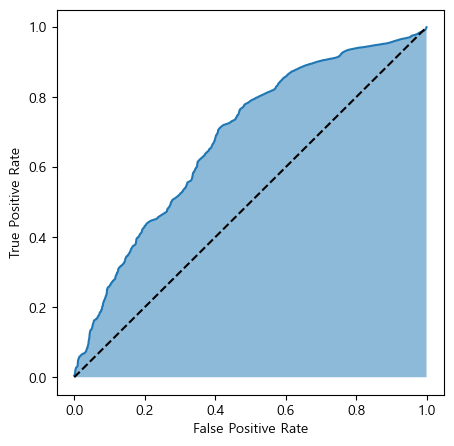

In [37]:
# ROC curve 그려봅니다.  # 참고용 코드
from sklearn.linear_model import LogisticRegression
X_cols = ['loading', 'na_1', 'na_2'] + ['measurement_{}'.format(i) for i in range(0, 18)]
clf = LogisticRegression(solver='lbfgs').fit(df_prob3_train[X_cols], df_prob3_train['failure'])
df_roc = pd.DataFrame({'prob': clf.predict_proba(df_prob3_test[X_cols])[:, 1],
 'label': df_prob3_test[target]})
df_roc.sort_values('prob', ascending=False, inplace=True) # Positive 확률에 따른 False Positive 수를 구하기 위해 정렬
df_roc['fp'] = df_roc['label'].cumsum() # Positive 확률까지의 누적 False Positive 수
df_roc = df_roc['fp'].value_counts().sort_index().cumsum().reset_index() # False Positive에 따른 True Positive 수를 구한다.
df_roc.columns = ['tp', 'fp']
df_roc['fp'] = df_roc['fp'].shift(1).fillna(0) # shift를 해야만 False Positive 따른 True Positive 수가 맞춰진다.
df_roc['tpr'] = df_roc['tp'] / df_roc['tp'].iloc[-1] # Rate로 환산, 마지막 수는 True의 수이다.
df_roc['fpr'] = df_roc['fp'] / df_roc['fp'].iloc[-1] # Rate로 환산, 마지막 수는 False의 수이다.

plt.figure(figsize=(5, 5))
plt.plot(df_roc['fpr'], df_roc['tpr'])
plt.fill_between(df_roc['fpr'], df_roc['tpr'], np.zeros_like(df_roc['tpr']), alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [38]:
from sklearn.metrics import roc_auc_score
# 간단한 roc_auc의 baseline을 만들어 봅니다
(
    roc_auc_score(df_prob3_train['failure'], df_prob3_train['loading']),
    roc_auc_score(df_prob3_test['failure'], df_prob3_test['loading'])
)

(0.5886355699157924, 0.5778277926972065)

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
# 입력 변수를 설정합니다.
X_lr = ['loading'] + ['measurement_{}'.format(i) for i in range(0, 18)] + ['na_1', 'na_2']
clf_lr = LogisticRegression(solver='lbfgs')
# 학습을 합니다.
clf_lr.fit(df_prob3_train[X_lr], df_prob3_train['failure'])
# 우선 train에 대한 성능을 측정해 봅니다.
roc_auc_score(df_prob3_train['failure'], clf_lr.predict_proba(df_prob3_train[X_lr])[:, 1])

0.5952982435574312

In [40]:
# test에 대한 성능을 측정합니다.
A = roc_auc_score(df_prob3_test['failure'], clf_lr.predict_proba(df_prob3_test[X_lr])[:, 1])
A

0.5792951262053387

## 단계 3-5

loading, measurement_0 ~ 17, na_1, na_2를 후보 입력 변수로 한다. 

전진 선택법을 사용하여 이 후보 입력 변수 중에서 최적의 성능을 보이는 입력 변수의 조합을 찾는다. 

전진 선택법의 선택 기준은 prob3_train을 대상으로 5겹 층화교차검증(5-Fold stratified cross validation)을 하고 

겹외(OOF, Out-Of Fold) 성능의 평균값으로 한다. 전진 선택 과정에서 선택했던 변수를 제외하지 않는다. 

입력 변수: 본 단계 요건 참고

대상 변수: failure 

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

mlxtend.feature_selection.SequentialFeatureSelector

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

문제 지시사항 외 Default 값 사용

---

In [41]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
# 대상 변수를 정의합니다.
X_sfs = ['loading'] + ['measurement_{}'.format(i) for i in range(0, 18)] + ['na_1', 'na_2']
# 속성선택기를 설정합니다.
sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(solver='lbfgs'), # Wrapper를 설정합니다.
    forward=True, # 전진 선택법
    k_features='best',# 최적의 성능을 보이는 입력 변수의 조합을 찾는다.
    cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),# 5겹 층화교차검증(5-Fold stratified cross validation)을 하고
    floating=False, # 전진 선택 과정에서 선택했던 변수를 제외하지 않는다.
    scoring='roc_auc' # roc_auc로 지표를 정의합니다.
)
sfs.fit(df_prob3_train[X_sfs], df_prob3_train['failure'])

c:\users\student\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


SequentialFeatureSelector(clone_estimator=True,
                          cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                          estimator=LogisticRegression(C=1.0, class_weight=None,
                                                       dual=False,
                                                       fit_intercept=True,
                                                       intercept_scaling=1,
                                                       l1_ratio=None,
                                                       max_iter=100,
                                                       multi_class='warn',
                                                       n_jobs=None,
                                                       penalty='l2',
                                                       random_state=None,
                                                       solver='lbfgs',
                                                       tol=0.0001, 

In [42]:
# sfs.subsets_ # 상세 결과를 제공합니다
sfs.k_feature_names_, sfs.k_score_

(('loading',
  'measurement_1',
  'measurement_4',
  'measurement_14',
  'measurement_17',
  'na_1'),
 0.5917537024093409)

In [43]:
X_sfs_best = list(sfs.k_feature_names_)
X_sfs_best

['loading',
 'measurement_1',
 'measurement_4',
 'measurement_14',
 'measurement_17',
 'na_1']

## 단계 3-6

단계 3-5에서 찾은 최적의 입력 변수 조합으로 로지스틱 회귀모델을 사용하여 prob3_train을 학습하고 

prob3_test로 성능을 측정한 값을 B라고 한다.

입력 변수: **단계 3-5**에서 도출한 최적의 입력 변수 조합

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수 가이드**

sklearn.linear_model.LogisticRegression, solver='lbfgs'

sklearn.metrics.roc_auc_score

문제 지시사항 외 Default 값 사용

---

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(df_prob3_train[X_sfs_best], df_prob3_train['failure'])
roc_auc_score(df_prob3_train['failure'], clf_lr.predict_proba(df_prob3_train[X_sfs_best])[:, 1])

0.5936682060775388

In [45]:
B = roc_auc_score(df_prob3_test['failure'], clf_lr.predict_proba(df_prob3_test[X_sfs_best])[:, 1])
B

0.5838326230092876

In [46]:
A - B

-0.004537496803948882

A-B값을 소수점 넷째 자리에서 반올림하여 셋째 자리까지 출력하시오

**-0.005**

# 문제 4

차원 축소 기법을 통한 데이터의 특성과 failure 분류 성능을 높힐 만한 요소를 살펴 본다. 

첫째로, loading을 제외하고, measurement_0 ~ 17을 입력으로 failure를 대상 변수로 Linear Discrimant Analysis(LDA) 모델을 만든다. 

범주가 두 개인 failure를 분류한다는 점에서 LDA 모델은 measurement_0 ~ 17를 한 개의 경계점으로 

failure를 최대한 정확하게 구분하도록 하나의 연속형 변수로 변환한다. 

실험 대상의 내구력을 나타낸다고 할 수 있는 LDA 변환값과 

실험에서 스프링에 가한 부하(loading)와 상관도를 측정하여, 

스프링에 따라 부하(loading)를 조정한 정도를 살펴본다.

둘째로, PCA를 사용하여 차원 감소로 failure 분류 성능에 얼마나 효과가 있을지 살펴본다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.


## 단계 4-1

prob3_train에서 measurement_0 ~ 17을 입력으로 failure를 대상 변수로 하여 LDA(Linear Discriminant Analysis) 모델을 학습한다. 

measurement_0 ~ 17에 대한 LDA의 변환값과 loading과 스피어만 상관도 (spearman correlation)의 p-value를 구하여 A라고 한다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

대상 변수] failure

---
**함수가이드**

sklearn.discriminant_analysis 제공 기능 활용

scipy.stats.spearmanr

문제 지시사항 외 Default 값 사용

---

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# lda 모델을 생성합니다.
lda = LinearDiscriminantAnalysis()
X_lda = ['measurement_{}'.format(i) for i in range(0, 18)]
lda.fit(df_prob3_train[X_lda], df_prob3_train['failure'])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [48]:
from scipy.stats import spearmanr
result_4_1 = spearmanr(
    lda.transform(df_prob3_train[X_lda])[:, 0], # lda 모델의 변환값(투영값)은 transform으로 얻습니다.
    df_prob3_train['loading']
)
A = result_4_1.pvalue
result_4_1, A

(SpearmanrResult(correlation=0.0029462997112993335, pvalue=0.6995009550811424),
 0.6995009550811424)

In [49]:
lda.predict(df_prob3_train[X_lda]) # 예측값을 반환합니다.

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

## 단계 4-2

prob3_train에서 measurement_0 ~ 17을 대상으로 주성분분석(Principal Component Analysis, PCA) 모델을 학습한다. 

분산 설명율이 높은 순으로 주성분을 변수명을 pca_0 ~ 17하여 prob3_train에 추가하여 prob4_train을 만든다. 

prob3_test에 prob3_train를 학습했던 PCA 모델로 동일한 방법으로 pca0 ~17 파생 변수를 추가하여 prob4_test를 만든다.

입력 변수] measurement_0 ~ 17 (순서에 유의 하시오)

---
**함수가이드**

sklearn.decomposition.PCA, random_state=123

문제 지시사항 외 Default 값 사용

---


In [50]:
from sklearn.decomposition import PCA
X_pca = ['measurement_{}'.format(i) for i in range(0, 18)]
# n_components를 설정하지 않으면 모든 컴포넌트를 반환합니다.
# n_components가 0과 1사이의 실수이면 해당 변동율 이상을 설명하기 위한 최소컴포넌트수로 설정됩니다.
# n_components가 1 이상의 정수면 반환할 컴포넌트의 수입니다
pca = PCA(random_state=123)
df_prob4_train, df_prob4_test = df_prob3_train.copy(), df_prob3_test.copy()
pca_cols = ['pca_{}'.format(i) for i in range(0, 18)]
df_prob4_train[pca_cols] = pd.DataFrame(pca.fit_transform(df_prob3_train[X_pca]), index= df_prob3_train.index)
df_prob4_test[pca_cols] = pd.DataFrame(pca.transform(df_prob3_test[X_pca]), index= df_prob3_test.index)
df_prob4_train.isna().sum().sum(), df_prob4_test.isna().sum().sum()

(0, 0)

## 단계 4-3

초기에 loading을 입력 변수로 하여 prob4_train을 학습하고, prob4_test에 대한 성능을 측정한다.

여기에 pca_0에서 pca_17까지 입력 변수를 하나씩 추가 하면서, 

즉 분산 설명율이 높은 순으로 컴포넌트를 하나씩 추가하여 prob4_train를 학습하고 prob4_test의 성능을 측정 했을 때, 

최적의 성능을 보인 컴포넌트들의 분산 설명율의 합을 B라고 한다. (만일 없다면 B = 0이다.)

입력 변수: 설명 참고

대상 변수: failure

성능 지표: AUC(area under of ROC curve)

---
**함수가이드**

sklearn.linear_model.LogisticRegression, solver=’lbfgs’

---

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
# 초기의 입력 변수를 설정합니다.
X_inp = ['loading']
X_best = X_inp.copy()
# 초기 입력 변수의 성능을 측정합니다.
clf_lr = LogisticRegression(solver='lbfgs')
clf_lr.fit(df_prob4_train[X_inp], df_prob4_train['failure'])
best_score = roc_auc_score(df_prob4_test['failure'], clf_lr.predict_proba(df_prob4_test[X_inp])[:, 1])

for i in range(18): # 0 ~ 17까지 루프를 돌립니다.
    X_inp.append('pca_{}'.format(i)) # 변수를 추가합니다.
    # 학습을 합니다
    clf_lr.fit(df_prob4_train[X_inp], df_prob4_train['failure'])
    # 성능을 측정합니다.
    score = roc_auc_score(df_prob4_test['failure'], clf_lr.predict_proba(df_prob4_test[X_inp])[:, 1])
    if best_score < score: # best 여부를 체크합니다.
        best_score = score # best를 갱신합니다.
        X_best = X_inp.copy()
    print(i, score, best_score, X_best)

0 0.579565141627812 0.579565141627812 ['loading', 'pca_0']
1 0.5784170060859327 0.579565141627812 ['loading', 'pca_0']
2 0.5786498903164131 0.579565141627812 ['loading', 'pca_0']
3 0.5801256923420173 0.5801256923420173 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3']
4 0.5805735466314028 0.5805735466314028 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4']
5 0.5811103203542446 0.5811103203542446 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5']
6 0.581757510516433 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']
7 0.5808025223153578 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']
8 0.5801787834323228 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']
9 0.5801664063683251 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6']
10 0.5794231311040503 0.581757510516433 ['loading', 'pca_0', 'pca_1', 'pca_

In [52]:
B = np.sum(pca.explained_variance_ratio_[:7])
B

0.4905370453061068

In [53]:
A + B

1.1900380003872493

A + B를 소수점 셋째 자리에서 반올림하여 둘째 자리까지 구하라.

**1.19**

# 문제 5

랜덤포레스트 분류기(Random-Forest Classifier)의 최적의 하이퍼 파라미터(Hyper-Parameter, 초매개변수)를 탐색하고자 한다.

문제3에서 사용했던, 전처리(loading 결측치 처리와 표준화 과정을 거친) 과정을 거친 prob3_train과 prob3_test를 사용한다.

## 단계 5-1

sklearn에서 제공하는 랜덤포레스트 분류기(Random-Forest Classifier)의 하이퍼 파라미터 중 

n_estimators, max_depth 그리고 min_samples_split의 최적 조합을 탐색한다. 

탐색 값은 아래에 제공한 하이퍼 파라미터의 모든 조합이다. 

prob3_train을 대상으로 5-겹 층화교차검증(5-fold stratified cross validation)으로 

각각 층의 겹외셋(OOF set, Out-Of-Fold set)의 성능에 대한 평균을 기준으로 하이퍼 파라미터를 선택한다.

  - n_estimators: [5, 10, 15]

  - max_depth: [5, 6, 7]
  
  - min_samples_split: [256, 512]

Hint] 모든 하이퍼 파라미터의 조합의 수는 18개이다

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

itertools.product 필요시 사용

sklearn.model_selection.cross_val_score 필요시 사용

sklearn.model_selection.StratifiedKFold, random_state=123, shuffle=True

sklearn.model_selection.GridSearchCV 필요시 사용

---

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# 방법 1 GridSearchCV를 활용합니다.

# Grid Search의 후보 매개 변수에 대한 parameter grid를 만듭니다.
param_grid = {
    'n_estimators': [5, 10, 15], 
    'max_depth': [5, 6, 7], 
    'min_samples_split': [256, 512]
}
X_srch = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
gscv = GridSearchCV(
    RandomForestClassifier(random_state=123),
    param_grid=param_grid,
    cv = cv,
    iid=False, # 겹외셋에 
    scoring='roc_auc', # _score로 끝나면, _score를 뺍니다. roc_auc_score-> roc_auc / 
                       # _error로 끝나면, 앞에 neg_를 붙입니다. mean_squared_error -> neg_mean_squared_error
)
gscv.fit(df_prob3_train[X_srch], df_prob3_train['failure'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=

In [55]:
gscv.best_params_, gscv.best_score_

({'max_depth': 7, 'min_samples_split': 512, 'n_estimators': 15},
 0.5745226991354744)

In [56]:
from sklearn.metrics import make_scorer, roc_auc_score
# scoring에 전달을 위한 make_scorer를 통해 scorer를 만듭니다.
my_scorer = make_scorer(roc_auc_score, needs_proba=True)

In [57]:
import itertools
from sklearn.model_selection import cross_val_score
# 방법 2: 반복문을 이용한 방법 입니다.

X_srch = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
best_param = None
best_score = 0
# itertools.product로 변수의 조합을 만들어 냅니다.
for n_estimators, max_depth, min_samples_split in itertools.product([5, 10, 15], [5, 6, 7], [256, 512]):
    param = {
        'n_estimators': n_estimators, 
        'max_depth': max_depth, 
        'min_samples_split': min_samples_split
    }
    clf_rf = RandomForestClassifier(
        **param, random_state=123
    )
    # 교차 검증을 합니다.
    scores_ = cross_val_score(
        clf_rf, df_prob3_train[X_srch], df_prob3_train['failure'], cv=cv, scoring=my_scorer
    )
    # 교차검증을 통한 겹외셋의 성능에 대한 평균을 구합니다.
    score = np.mean(scores_)
    if best_score < score: # 가장 좋은 결과를 체크하고, 남깁니다
        best_score = score
        best_param = param
    print(score, best_score, best_param)
best_score, best_param

0.5547115468443294 0.5547115468443294 {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 256}
0.5617150416141751 0.5617150416141751 {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 512}
0.5568999583940097 0.5617150416141751 {'n_estimators': 5, 'max_depth': 5, 'min_samples_split': 512}
0.5623239919998733 0.5623239919998733 {'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 512}
0.5567633668997499 0.5623239919998733 {'n_estimators': 5, 'max_depth': 6, 'min_samples_split': 512}
0.5642015275666604 0.5642015275666604 {'n_estimators': 5, 'max_depth': 7, 'min_samples_split': 512}
0.5654552370913933 0.5654552370913933 {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 256}
0.5707474621000601 0.5707474621000601 {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 512}
0.5681316681217556 0.5707474621000601 {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 512}
0.5680847464819798 0.5707474621000601 {'n_estimators': 10, 'max_depth': 5, 'min_samples_split': 5

(0.5745226991354744,
 {'n_estimators': 15, 'max_depth': 7, 'min_samples_split': 512})

## 단계 5-2

단계 5-1에서 구한 최적 하이퍼 파라미터로 설정한 랜덤포레스트 분류기(Random-Forest Classifier)를 사용하여 prob3_train 학습하고, 

prob3_test로 성능을 측정하여 이 값을 A라고 한다.

입력 변수: loading, measurement_0 ~ 17, na_1, na_2 (순서에 유의)

대상 변수: failure

성능 지표: AUC (area under of ROC curve)

---
**함수가이드**

sklearn.ensemble.RandomForestClassifier, random_state=123 

---


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

clf_rf = RandomForestClassifier(**best_param, random_state=123)
X_srch = ['loading'] + ['measurement_{}'.format(i) for i in range(18)] + ['na_1', 'na_2']
clf_rf.fit(df_prob3_train[X_srch], df_prob3_train['failure'])
roc_auc_score(df_prob3_train['failure'], clf_rf.predict_proba(df_prob3_train[X_srch])[:, 1])

0.6416568062149542

In [59]:
A = roc_auc_score(df_prob3_test['failure'], clf_rf.predict_proba(df_prob3_test[X_srch])[:, 1])
A

0.5687712018291998

A값을 소수점 넷째 자리에서 반올림하여 3째 자리까지 출력하시오.

**0.569**